<a href="https://colab.research.google.com/github/JaeHeee/Pytorch_Tutorial/blob/main/code/TRAINING_A_CLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TRAINING A CLASSIFIER

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 NumPy 배열로 불러오고 그 후 그 배열을 `torch.*Tensor` 로 변환

영상 분야를 위한 `torchvision` 이라는 패키지가 만들어져 있는데, 여기에는 Imagenet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader), 즉 `torchvision.datasets` 과 이미지용 데이터 변환기 (data transformer), 즉 `torch.utils.data.DataLoader` 가 포함  

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서 작성하는 것을 피할 수 있다.

### Training an image classifier

1. `torchvision` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을 불러오고, 정규화(nomarlizing)

2. 합성곱 신경망(Convolution Neural Network)을 정의

3. 손실 함수를 정의

4. 학습용 데이터를 사용하여 신경망을 학습

5. 시험용 데이터를 사용하여 신경망을 검사

#### 1. Loading and normalizing CIFAR10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    print(np.transpose(npimg, (1,2,0)).shape)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [ ]:
# image 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

(3, 32, 32)
(32, 32, 3)


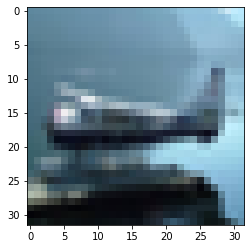

In [ ]:
imshow(images[0])

#### 2. Define a Convolutional Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [ ]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # gradient 매개변수를 0으로
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.203
[1,  4000] loss: 1.840
[1,  6000] loss: 1.654
[1,  8000] loss: 1.593
[1, 10000] loss: 1.532
[1, 12000] loss: 1.480
[2,  2000] loss: 1.393
[2,  4000] loss: 1.354
[2,  6000] loss: 1.359
[2,  8000] loss: 1.317
[2, 10000] loss: 1.297
[2, 12000] loss: 1.271


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[PyTorch 모델을 저장하는 자세한 방법](https://pytorch.org/docs/stable/notes/serialization.html)

### 5. Test the network on the test data

(3, 36, 138)
(36, 138, 3)


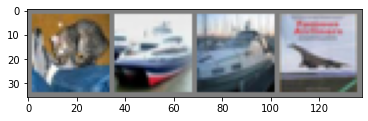

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
outputs

tensor([[-1.2528, -1.8003,  0.8221,  1.9262,  0.1079,  0.8157,  1.2695, -0.4075,
          0.0395, -1.4327],
        [ 3.8827,  4.7485, -1.4407, -1.8937, -2.4961, -4.0124, -2.9979, -3.1677,
          5.0311,  1.3584],
        [ 1.2227,  2.1541, -0.0943, -0.2881, -1.4103, -1.4242, -0.9420, -1.9605,
          2.4444,  0.4674],
        [ 3.2275,  0.0632,  1.0682, -0.3939,  0.0736, -2.3768, -1.9223, -2.3157,
          2.4147, -0.7134]], grad_fn=<AddmmBackward>)

In [ ]:
torch.max(outputs, 1)[0]

tensor([1.9262, 5.0311, 2.4444, 3.2275], grad_fn=<MaxBackward0>)

In [ ]:
torch.max(outputs, 1)[1]

tensor([3, 8, 8, 0])

In [ ]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


In [ ]:
print((predicted == labels))
print((predicted == labels).sum())
print((predicted == labels).sum().item())
print((predicted == labels).squeeze())

tensor([True, True, True, True])
tensor(4)
4
tensor([True, True, True, True])


전체 데이터세에 대한 동작

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

print(class_correct)
print(class_total)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # c = (predicted == labels).squeeze()
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct)
print(class_total)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[495.0, 665.0, 205.0, 473.0, 461.0, 590.0, 705.0, 595.0, 627.0, 509.0]
[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Accuracy of plane : 49 %
Accuracy of   car : 66 %
Accuracy of  bird : 20 %
Accuracy of   cat : 47 %
Accuracy of  deer : 46 %
Accuracy of   dog : 59 %
Accuracy of  frog : 70 %
Accuracy of horse : 59 %
Accuracy of  ship : 62 %
Accuracy of truck : 50 %


### Training on GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


다음 method들은 재귀적으로 모든 module의 매개변수와 buffer를 CUDA tensor로 변경

In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

각 단계에서 input과 target도 GPU로 보내야한다.

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)

모든 GPU를 활용해서 속도를 더 올리고 싶은 경우 [Data Parallelism](https://tutorials.pytorch.kr/beginner/blitz/data_parallel_tutorial.html)